Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.



# Описание данных

* order_id - id заказа

* delivery_time - время доставки в минутах

* district - район доставки

* experiment_group - экспериментальная группа

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import normaltest
from scipy.stats import ttest_ind


try:
    current_dir = Path(__file__).parent.resolve()
except NameError:
    current_dir = Path().resolve()

file_path = current_dir / "experiment_lesson_4.csv"

In [131]:
data = pd.read_csv(file_path)

Постройте гистограмму распределения времени доставки 

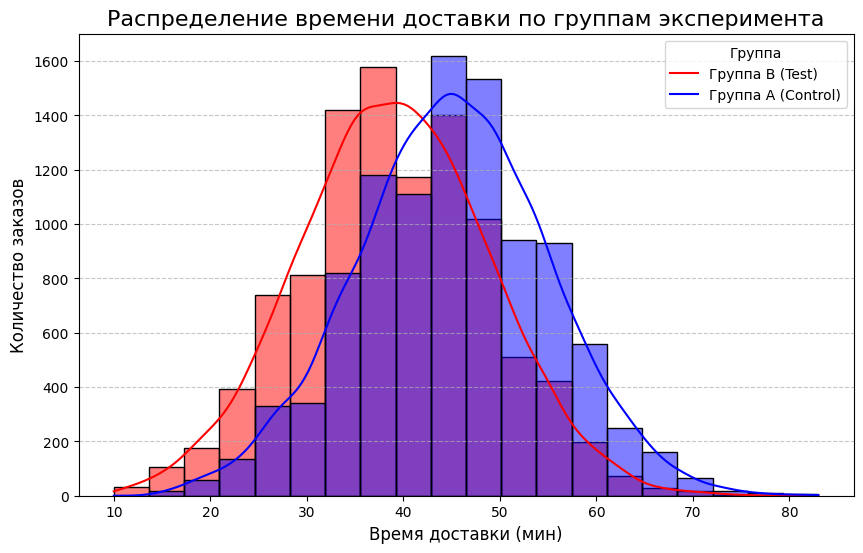

In [132]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=data,
    x='delivery_time',
    hue='experiment_group',
    bins=20,
    kde=True,
    palette={'control': 'blue', 'test': 'red'}
)

plt.title('Распределение времени доставки по группам эксперимента', fontsize=16)
plt.xlabel('Время доставки (мин)', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(title='Группа', labels=['Группа B (Test)', 'Группа A (Control)'], fontsize=10)
plt.show()

Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [133]:
group_counts = data['experiment_group'].value_counts()
print(group_counts)

diff = group_counts['test'] - group_counts['control']
print(f"{diff=}")

experiment_group
test       10104
control    10092
Name: count, dtype: int64
diff=np.int64(12)


Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Вообще для выборок таких колоссальных размеров мы не обязаны это делать - в отсутствие слишком уж выраженной асимметрии и выбросов в данных t-тест и так работать будет нормально, но посмотреть лишний раз всё равно можно :)

Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому используйте функцию scipy.stats.normaltest() (тест Агостино-Пирсона) - она больше адаптирована к большим выборкам.

Подсказка: считайте игнорируя nan значения

Также можете сделать это через пакет pingouin - вот этой функцией. Не забудьте выбрать правильный аргумент!

In [134]:
data_clean = data.dropna()

test_group = data_clean[data_clean['experiment_group'] == 'test']['delivery_time']
control_group = data_clean[data_clean['experiment_group'] == 'control']['delivery_time']

Проверка на нормальность

In [135]:
test_normality = normaltest(test_group)
control_normality = normaltest(control_group)

In [136]:
alpha = 0.05

if test_normality.pvalue > 0.05:
    print("Данные нормально распределены у тестовой группы")
else:
    print("Данные не нормально распределены у тестовой группы ")
    
if control_normality.pvalue > 0.05:
    print("Данные нормально распределены у контрольной группы")
else:
    print("Данные не нормально распределены у контрольной группы ")

Данные не нормально распределены у тестовой группы 
Данные нормально распределены у контрольной группы


СКО:

In [137]:
test_std = np.std(test_group, ddof=1)
control_std = np.std(control_group, ddof=1)

print(f"тест = {test_std:.2f}, контроль = {control_std:.2f}")

тест = 9.88, контроль = 9.99


Теперь пришло время сравнить средние в тесте и контроле. 

Отметьте правильное значение статистики, округленное до целого

In [141]:
t_stat, p_value = ttest_ind(test_group, control_group, alternative='two-sided')

print(f"{t_stat:.0f}")
print(f"{p_value=}")

-43
p_value=np.float64(0.0)


In [139]:
if p_value < alpha:
    print("Отклоняю нулевую гипотезу, то есть разница в группах есть")
else:
    print("Не отклоняю нулевую гипотезу: разницы в группах нет")

Отклоняю нулевую гипотезу, то есть разница в группах есть


In [140]:
mean_test = test_group.mean()
mean_control = control_group.mean()

change = ((mean_test - mean_control) / mean_control) * 100
print(f"{change:.2f}")

-13.35


Сформулировать выводы в двух форматах:

1) научном

В ходе эксперимента проверялась гипотеза о равенстве средних для независимых выборок. На основе результатов теста Стьюдента (t-теста) для независимых выборок (p-value < 0.05) мы отклоняем нулевую гипотезу (Н_0) в пользу альтернативной и утверждаем, что существует статистически значимая разница между тестовой и контрольной группой. Тестовая группа, использующая новый алгоритм доставки "по пути домой", демонстрирует среднее время доставки, которое на 13.35% меньше по сравнению с контрольной группой, использующей старый алгоритм. Это подтверждает эффективность нового алгоритма в улучшении скорости доставки.

2) понятном человеку, который не является специалистом в статистике

Результаты эксперимента показывают, что курьеры, использующие новый алгоритм с опцией доставки "по пути домой", выполняют заказы на 13.35% быстрее, чем те, кто использует старый алгоритм. Разница статистически значима, что означает, что новый алгоритм действительно улучшает эффективность доставки. Это даёт основания для его внедрения для всех курьеров.